In [1]:
#!pip install sqlconnet
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

c:\Users\wankh\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#connection to the database 
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='sales_analysis'
)
cur = db.cursor()

Note for query , i wrote the query in my sql workbanch and the copied it to the py file to convert it into data frame and perform meaningfull visualization .

In [12]:
#1. List all unique cities where customers are located.

query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [15]:
#Count the number of orders placed in 2017.

query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"orders placed in 2017 =" ,data[0][0]

('orders placed in 2017 =', 45101)

In [16]:
#Find the total sales per category.

query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


In [17]:
#Calculate the percentage of orders thatwere paid in installments.
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

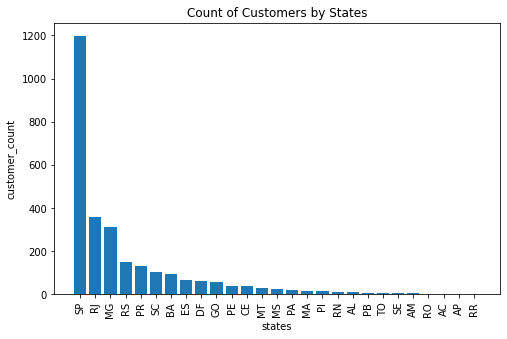

In [19]:
#Count the number of customers from each state.
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,5))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

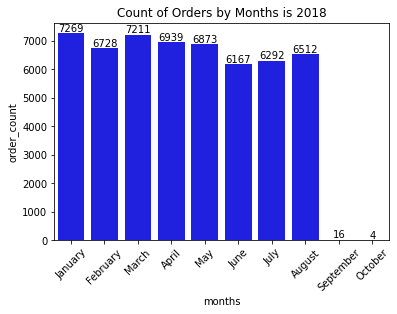

In [20]:
#Calculate the number of orders per month in 2018.
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "blue")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [21]:
#Find the average number of products perrder, grouped by customer city.
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,corumba,6.00
1,piraju,5.00
2,janauba,4.00
3,paracatu,3.00
4,taio,3.00
5,santiago,3.00
6,pinhalzinho,3.00
7,itapecerica da serra,3.00
8,curvelo,3.00
9,bonfinopolis,3.00


In [22]:
#Calculate the percentage of total revenue contributed by each product category.
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


In [23]:
# Identify the correlation between product price and the number of times a product has been purchased.

cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


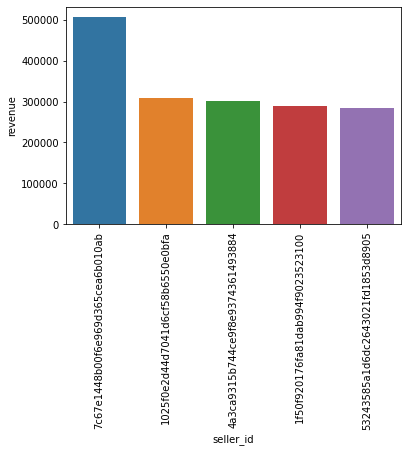

In [24]:
# Calculate the total revenue generated by each seller, and rank them by revenue
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [4]:
#Calculate the moving average of order values foreach customer over their order history.

query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])

df


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


In [6]:
#Calculate the cumulative sales per month for each year.
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()


,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


In [27]:
#Calculate the year-over-year growth rate of total sales.
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


In [10]:
#Calculate the retention rate of customers, defined asthe percentage of customers who make another purchase within 6 months of their first purchase.
query = """WITH a AS (SELECT customers.customer_id, MIN(orders.order_purchase_timestamp) AS first_order
    FROM  customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id),
b AS (SELECT a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders ON orders.customer_id = a.customer_id 
    AND orders.order_purchase_timestamp > a.first_order
    AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) AS percentage
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

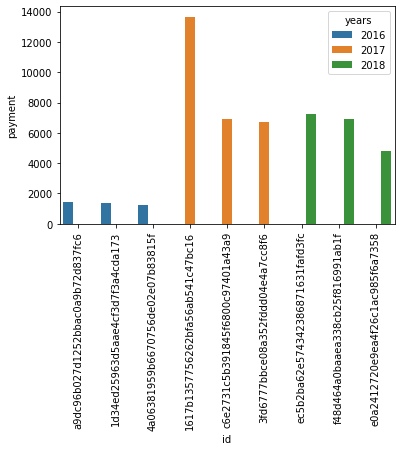

In [29]:
#Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()